In [303]:
imagename = '4YIO'
#imagename = 'FBAP'
imagename = 'PI17'

# https://www.interasia.cc/content/c_service/cargo_tracking.aspx?SiteID=1

# Load Image (Palette)

In [304]:
from PIL import Image, ImageFilter, ImageEnhance
from IPython.display import display
import pytesseract as tess
import os
from collections import Counter

ims = []
dirname = os.path.join(os.getcwd(), imagename)
for filename in os.listdir(dirname) :
    fullname = os.path.join(dirname, filename)
    #print(fullname)
    im = Image.open(fullname)
    display(im)
    ims.append(im)

# Convert to RGB

In [305]:
ims_rgb = []
for im in ims :
    im_rgb = im.convert("RGB")
    #display(im_rgb)
    ims_rgb.append(im_rgb)

# pixelwise median image

In [306]:
def median_image ( ims_rgb ) :
    from statistics import median
    
    im_processed = Image.new("RGB", ims[0].size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    for x in range(1,im_processed.size[0]-1) :
        for y in range(1,im_processed.size[1]-1) :
            
            rs = []
            gs = []
            bs = []
            for im in ims_rgb :
                rgb = im.load()[x,y]
                rs.append(rgb[0])
                gs.append(rgb[1])
                bs.append(rgb[2])
            
            r = int(median(rs))
            g = int(median(gs))
            b = int(median(bs))
        
            pix_processed[x,y] = ( r, g, b )
    
    return im_processed

# pixelwise statistics image

In [307]:
def statistics_image ( ims_rgb ) :
    from statistics import median
    
    im_processed = Image.new("RGB", ims[0].size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    for x in range(1,im_processed.size[0]-1) :
        for y in range(1,im_processed.size[1]-1) :
            
            rs = []
            gs = []
            bs = []
            for im in ims_rgb :
                rgb = im.load()[x,y]
                rs.append(rgb[0])
                gs.append(rgb[1])
                bs.append(rgb[2])
            
            r = int(Counter(rs).most_common(1)[0][0])
            g = int(Counter(gs).most_common(1)[0][0])
            b = int(Counter(bs).most_common(1)[0][0])
        
            pix_processed[x,y] = ( r, g, b )
    
    return im_processed

# image-wise 9-median, stack-wise median

In [308]:
def median_image_single ( ims_rgb, stencil ) :
    from statistics import median
    
    def pattern ( pix, x, y ) :
        def indexed ( pix, x, y, idx ) :
            return pix[x,y][idx]
        r = []
        g = []
        b = []
        for dx in range(-stencil,stencil) :
            for dy in range(-stencil,stencil) :
                r.append( pix[x+dx,y+dy][0] )
                g.append( pix[x+dx,y+dy][1] )
                b.append( pix[x+dx,y+dy][2] )
        return (median( r ), median(g), median(b) )
    
    im_processed = Image.new("RGB", ims[0].size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    for x in range(stencil,im_processed.size[0]-stencil) :
        for y in range(stencil,im_processed.size[1]-stencil) :
            
            rs = []
            gs = []
            bs = []
            white = False
            for im in ims_rgb :
                rgb = pattern(im.load(),x,y)
                rs.append(rgb[0])
                gs.append(rgb[1])
                bs.append(rgb[2])
                white |= im.load()[x,y] == (255,255,255)
            
            if white :
                r = g = b = 255
            else :                
                r = int(median(rs))
                g = int(median(gs))
                b = int(median(bs))
      
            pix_processed[x,y] = ( r, g, b )
    
    return im_processed

# image&stack-wise 9xN-median

In [309]:
def median_image_stack ( ims_rgb, stencil ) :
    from statistics import median
    
    def pattern ( pix, x, y ) :
        def indexed ( pix, x, y, idx ) :
            return pix[x,y][idx]
        r = []
        g = []
        b = []
        for dx in range(-stencil,stencil) :
            for dy in range(-stencil,stencil) :
                r.append( pix[x+dx,y+dy][0] )
                g.append( pix[x+dx,y+dy][1] )
                b.append( pix[x+dx,y+dy][2] )
        return [r, g, b]
    
    im_processed = Image.new("RGB", ims[0].size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    for x in range(stencil,im_processed.size[0]-stencil) :
        for y in range(stencil,im_processed.size[1]-stencil) :
            
            rs = []
            gs = []
            bs = []
            white = False
            for im in ims_rgb :
                rgb = pattern(im.load(),x,y)
                rs.extend(rgb[0])
                gs.extend(rgb[1])
                bs.extend(rgb[2])                
                white |= im.load()[x,y] == (255,255,255)         
                
            if white :
                r = g = b = 255
            else :
                r = int(median(rs))
                g = int(median(gs))
                b = int(median(bs))
      
            pix_processed[x,y] = ( r, g, b )
    
    return im_processed

# whiten stack

In [310]:
def whiten_stack ( ims_rgb_orig ) :

    ims_rgb = []
    for im in ims_rgb_orig :
        ims_rgb.append( im.copy() )

    size = ims_rgb[0].size
        
    for x in range(0,size[0]) :
        for y in range(0,size[1]) :
            
            white = False
            for im in ims_rgb :
                white |= im.load()[x,y] == (255,255,255)         
                
            if white :
                for im in ims_rgb :
                    im.load()[x,y] = (255,255,255)         
    
    return ims_rgb

In [311]:
ims_rgb_whiten = whiten_stack( ims_rgb )
for im in ims_rgb_whiten :
    display(im)
#ims_rgb = ims_rgb_whiten

# grey filter

In [312]:
def grey_filter( im, lightness, colorness ) :

    im_processed = Image.new("RGB", ims[0].size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    for x in range(1,im_processed.size[0]) :
        for y in range(1,im_processed.size[1]) :
         
            rgb = im.load()[x,y]
            r = rgb[0]
            g = rgb[1]
            b = rgb[2]
            
            # light color
            if (r+g+b)/3 > lightness :
                r = g = b = 255
            # shade of grey
            if max(r,g,b)-min(r,g,b) < colorness :
                r = g = b = 255             
                
            pix_processed[x,y] = ( r, g, b )
            
    return im_processed

In [313]:
def grey_filter_hsv( im, minsaturation, mindarkness ) :

    im_processed = Image.new("RGB", ims[0].size, (255, 255, 255))
    pix_processed = im_processed.load()
    
    im_hsv = im.convert('HSV')
    pix_hsv = im_hsv.load()
    
    for x in range(1,im_processed.size[0]) :
        for y in range(1,im_processed.size[1]) :
         
            rgb = im.load()[x,y]
            r = rgb[0]
            g = rgb[1]
            b = rgb[2]
            
            saturation = pix_hsv[x,y][1]
            darkness = 255 - pix_hsv[x,y][2]

            # not enough saturation and not dark enough?
            if saturation < minsaturation & darkness < mindarkness :
                r = g = b = 255
                
            pix_processed[x,y] = ( r, g, b )
            
    return im_processed

# tesseract call

In [314]:
def image_2_text( im ):
    
    def call_tesseract( im, psm ) :
        text = tess.image_to_string(im, config='--psm ' + str(psm)).strip() # , lang='eng'
        #print(text)
        return text
    
    recognized = []
    recognized.append(call_tesseract(im,6))
    recognized.append(call_tesseract(im,7))
    #recognized.append(call_tesseract(im,8))
    #recognized.append(call_tesseract(im,13))
    return Counter(recognized)

# compare image processors

In [315]:
im_processed = median_image( ims_rgb )
display(im_processed)
print(image_2_text( im_processed ))

im_processed = statistics_image( ims_rgb )
display(im_processed)
print(image_2_text( im_processed ))

im_processed = median_image_single( ims_rgb , 1 )
display(im_processed)
print(image_2_text( im_processed ))

im_processed = median_image_stack( ims_rgb , 1 )
display(im_processed)
print(image_2_text( im_processed ))

Counter({'PHS.': 2})


Counter({'PHT7 ©': 2})


Counter({'PI17': 2})


Counter({'PI17': 2})


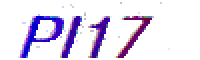

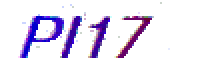

Counter({'PI17': 2})


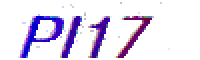

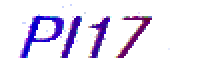

Counter({'PI17': 2})


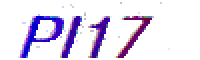

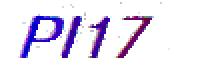

Counter({'PI17': 2})


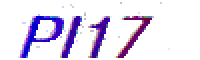

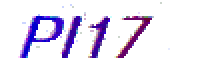

Counter({'PI17': 2})

Totals: Counter({'PI17': 8})


In [316]:
recognized = Counter()

for minsaturation in (30,50,70,90) :
    im_processed = median_image_stack( ims_rgb , 1 )
    display(im_processed.resize((200,60), resample=Image.NEAREST))
    
    im_processed = grey_filter_hsv ( im_processed, minsaturation, 100 )
    display(im_processed.resize((200,60), resample=Image.NEAREST))

    text = image_2_text( im_processed )
    recognized += text
    print(text)
    
print("\nTotals: " + str(recognized))

In [317]:
#im_processed = remove_dots(im_processed, 150)
#display(im_processed)

im_processed = im_processed.filter(ImageFilter.MedianFilter(3))
display(im_processed)

print(image_2_text( im_processed ))

im_tess = Image.new("RGB", im_processed.size, (255, 255, 255))
im_tess.paste(im_processed)
#im_tess = im_tess.filter(ImageFilter.MedianFilter(1))
im_tess = im_tess.convert('1')
display(im_tess)

print(image_2_text( im_tess ))

Counter({'PI17': 2})


Counter({'Yt?': 2})
